### Welcome to the program
Anything you will need will be in this file.

First let some modules to download

In [1]:
!pip install ipywidgets;


In [8]:
import utils
import os

import torch

import ipywidgets as widgets
from IPython.display import display

from fairness_metrics.predicted_probs.balance_in_pos_neg import balance_in_pos_neg
from fairness_metrics.predicted_probs.well_callibrated import well_calibration
from fairness_metrics.Predicted_outcomes.unconditional_statistical_parity import statistical_parity
from fairness_metrics.similarity_based.similarity_based import LipschitzFairness

In [ ]:

INPUT_FILE_NAME = widgets.Text(
    placeholder='Type file name',
    description='File name:',
    tooltip='do not forget the file extension'
)
PRESET_FILENAME = INPUT_FILE_NAME.value if INPUT_FILE_NAME.value else 'No file'
file_exits = os.path.exists(utils.SAVED_PRESET_PATH + PRESET_FILENAME)
FILE_FOUND = widgets.Valid(
    value=file_exits,
    style = {'description_width': 'initial'},
    description=f'Preset file "{PRESET_FILENAME}"',
    tooltip='Indicates if the chosen file has been found'
)
USE_PRESET= widgets.RadioButtons(
    options=[('Yes', 1), ('No', 0)],
    value=file_exits,
    disabled=not(file_exits),
    style = {'description_width': 'initial'},
    description='Load params file:',
)

info_box = widgets.VBox([
    widgets.Label(value=f'Select your params file here, They must be in the folder "{utils.SAVED_PRESET_PATH}"'),
    INPUT_FILE_NAME,
    FILE_FOUND,
    USE_PRESET,
])

output_file_selection = widgets.Output()
display(info_box, output_file_selection)

def update_file_name_info(_):
    with output_file_selection:
        PRESET_FILENAME = INPUT_FILE_NAME.value if INPUT_FILE_NAME.value else 'No file'
        file_exits = os.path.exists(os.path.join(utils.SAVED_PRESET_PATH + PRESET_FILENAME))
        FILE_FOUND.description = f'Preset file "{PRESET_FILENAME}"'
        FILE_FOUND.value = file_exits
        USE_PRESET.value = file_exits
        USE_PRESET.disabled=not(file_exits)

INPUT_FILE_NAME.on_trait_change(update_file_name_info)

Output()

In [ ]:
# dataset = utils.Dataset(utils.DATA_PATH_SYNTH)
dataset = utils.Dataset('data/altered_data/alt_data_balenced_pred_biased.csv')
display(widgets.Label(value='dataset has been loaded'))

params = {}
if USE_PRESET.value:
    params = torch.load(utils.SAVED_PRESET_PATH + INPUT_FILE_NAME.value, weights_only=True)

    display(widgets.Label(value=f'"{INPUT_FILE_NAME.value}" has been loaded'))

Label(value='dataset has been loaded')

Label(value='"preset1.pt" has been loaded')

In [ ]:
# testing column selection

from ipywidgets import Layout, VBox, Label, Box, Checkbox

style = {'background':'white'}
item_layout = Layout(width='auto')

protected_items = [Checkbox(layout=item_layout, description=dataset.i2c[i], indent=False, style=style) for i in range(len(dataset.i2c))]

box_layout = Layout(overflow='hidden scroll',
                    border='empty',
                    width='auto',
                    height='300px',
                    flex_flow='column',
                    display='flex',
                    padding='0')

PROTECTED_SELECTION = Box(children=protected_items, layout=box_layout)
GROUND_SELECTION = widgets.Combobox(
    value=None,
    placeholder='Choose a feature',
    options=dataset.i2c+[''],
    description='Ground truth:',
    ensure_option=True,
    style={'description_width':'150px'},
    layout=widgets.Layout(width='auto'),
)
PREDICTED_SELECTION = widgets.Combobox(
    value=None,
    placeholder='Choose a feature',
    options=dataset.i2c+[''],
    description='Predicted by model:',
    ensure_option=True,
    style={'description_width':'150px'},
    layout=widgets.Layout(width='auto'),
)
FEEDBACK_INFO_SLECETION = widgets.Label(
    value='',
)

SELECTION_BOX = VBox([
    Label('Please select the ground truth and the predicted probability (if available):'), 
    GROUND_SELECTION,
    PREDICTED_SELECTION,
    FEEDBACK_INFO_SLECETION,
    Label('Please select all protected variables:'), 
    PROTECTED_SELECTION,
    ])

if USE_PRESET.value:
    preset_protected_values = params.get('protected_values', torch.zeros(len(dataset.i2c), dtype=bool))
    for item, value in zip(protected_items, preset_protected_values):
        item.value = bool(value)
    GROUND_SELECTION.value=params.get('ground_truth_column', '')
    PREDICTED_SELECTION.value=params.get('prediction_column', '')

output_selection = widgets.Output()
display(SELECTION_BOX, output_selection)

def update_selection_feedback(id):
    with output_selection:
        if GROUND_SELECTION.value == PREDICTED_SELECTION.value != '':
            FEEDBACK_INFO_SLECETION.value=f'Both are now selected as "{GROUND_SELECTION.value}", Please make sure that the ground truth is not the same as the predictions'
        else:
            FEEDBACK_INFO_SLECETION.value='You have selected ' + (f'ground truth as "{GROUND_SELECTION.value}"' if GROUND_SELECTION.value else 'no ground truth') + ' and ' + (f'predictions as "{PREDICTED_SELECTION.value}"' if PREDICTED_SELECTION.value else 'no predictions')

GROUND_SELECTION.on_trait_change(update_selection_feedback)
PREDICTED_SELECTION.on_trait_change(update_selection_feedback)
SELECTION_BOX.on_widget_constructed(update_selection_feedback)

Output()

In [ ]:

style = {'background':'white'}
item_layout = Layout(width='auto')

fairness_groups_names = ['Predicted and actual outcomes',
                         'Predicted probibilities and actual outcomes',
                         'similarity based',
                         'Causal Reasoning']

metric_prob_names = ['Test-fairness', 'Balance in classes']


VALID_GROUND = widgets.Valid(value=True, description='Ground truth')
VALID_PRED = widgets.Valid(value=True, description='Prediction')

TEST_FAIRNESS = widgets.VBox([
    widgets.Label(value='Please, make a selections'),  ## label to explain
    VALID_GROUND, VALID_PRED,
])

BALANCE_IN_CLASS = widgets.VBox([
    widgets.Label(value='Please, make a selections'),  ## label to explain
    widgets.Checkbox(layout=item_layout, 
                     description='Show the positive balance', 
                     indent=False, 
                     style=style),
    widgets.Checkbox(layout=item_layout, 
                     description='Show the negative balance', 
                     indent=False, 
                     style=style),
    VALID_GROUND, VALID_PRED,
])

metrics_groups = [
    [TEST_FAIRNESS, BALANCE_IN_CLASS]
]

fairness_groups = [
    widgets.Accordion(children=metrics_groups[0], titles=metric_prob_names),
]

accordion = widgets.Accordion(children=fairness_groups, titles=fairness_groups_names)
accordion

Accordion(children=(Accordion(children=(VBox(children=(Label(value='Please, make a selections'), Valid(value=T…

In [ ]:
params['protected_values'] = torch.tensor([protected_item.value for protected_item in protected_items])
params['ground_truth_column'] = GROUND_SELECTION.value
params['prediction_column'] = PREDICTED_SELECTION.value

metric1 = balance_in_pos_neg(dataset, params)
metric2 = well_calibration(dataset, params)
metric3 = statistical_parity(dataset, params)
metric4 = LipschitzFairness(dataset, params)

In [20]:
sum(dataset.data[:,-2])/len(dataset.data)

tensor(0.4976, dtype=torch.float64)

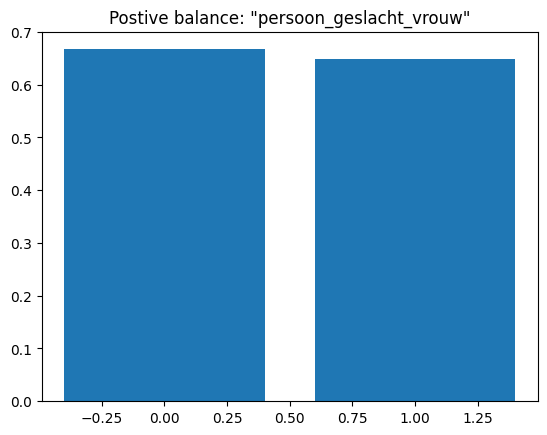

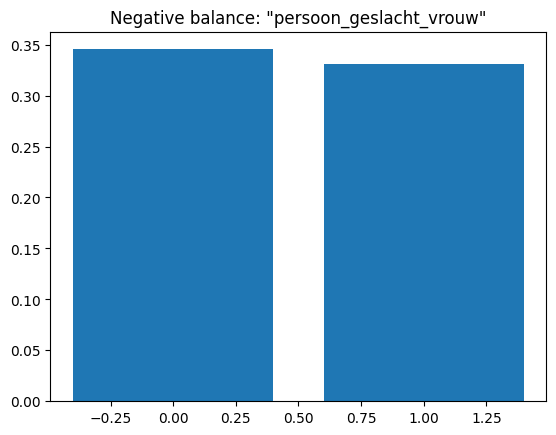

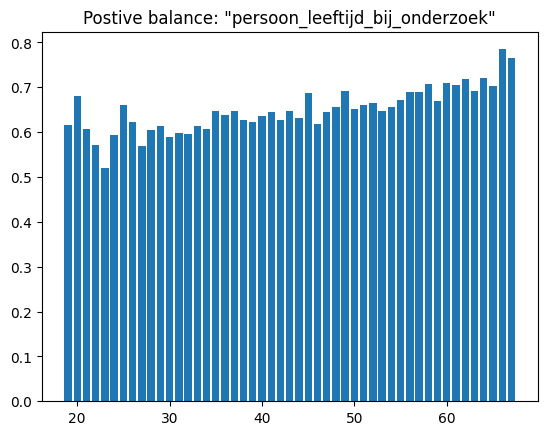

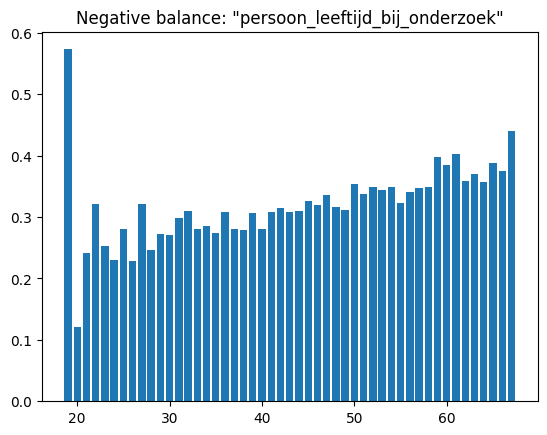

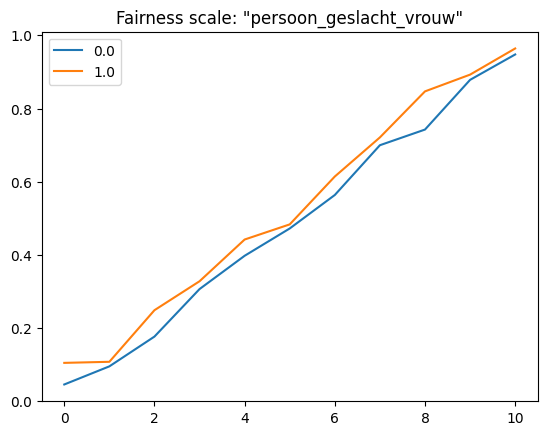

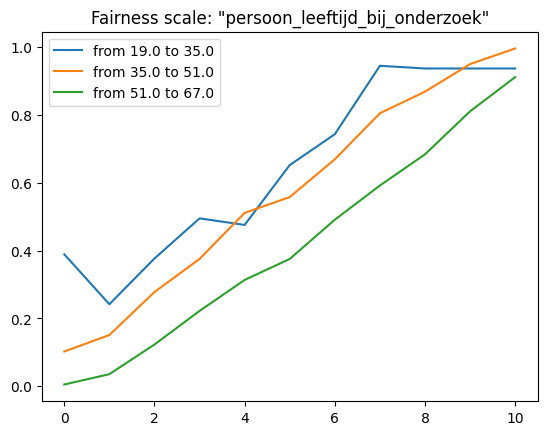

In [13]:
metric1.show() ## this should be the only steps
metric2.show()
# metric3.check_statistical_parity()

In [ ]:
pos, neg = [0,0],[0,0]
pos += [.5, 1]
pos

In [ ]:
OUTPUT_FILE_NAME = widgets.Text(
    placeholder='Type output file name',
    description='File name:',
    tooltip='do not forget the file extension'
)
FEEDBACK_INFO = widgets.Label(
    value='',
)
SUBMIT_BUTTON = widgets.Button(
    description='Save preset',
    disabled=True,
    button_style='danger',
    tooltip='No file name',
)

info_box = widgets.VBox([
    widgets.Label(value=f'Select a name for your preset file here, This will be saved in the folder "{utils.SAVED_PRESET_PATH}"'),
    OUTPUT_FILE_NAME,
    SUBMIT_BUTTON,
    FEEDBACK_INFO,
])

output_savefile = widgets.Output()
display(info_box, output_savefile)


def update_file_name_info(id):
    with output_savefile:
        if type(id) == widgets.Button:
            params['protected_values'] = torch.tensor([protected_item.value for protected_item in protected_items])
            params['ground_truth_column'] = GROUND_SELECTION.value
            params['prediction_column'] = PREDICTED_SELECTION.value

            torch.save(params, utils.SAVED_PRESET_PATH + OUTPUT_FILE_NAME.value)
            FEEDBACK_INFO.value=f'Preset saved to "{OUTPUT_FILE_NAME.value}"'
        
        if type(id) == widgets.Text:
            FEEDBACK_INFO.value=''
        
        file_exits = os.path.exists(utils.SAVED_PRESET_PATH + OUTPUT_FILE_NAME.value)
        if OUTPUT_FILE_NAME.value == '':
            SUBMIT_BUTTON.button_style='danger'
            SUBMIT_BUTTON.tooltip='No file name'
            SUBMIT_BUTTON.disabled=True
        elif not OUTPUT_FILE_NAME.value.endswith('.pt'):
            SUBMIT_BUTTON.button_style='warning'
            SUBMIT_BUTTON.tooltip='Please make it a .pt file'
            SUBMIT_BUTTON.disabled=False
        elif file_exits:
            SUBMIT_BUTTON.button_style='info'
            SUBMIT_BUTTON.tooltip='A file already exists with this name, overwrite is possible'
            SUBMIT_BUTTON.disabled=False
        else:
            SUBMIT_BUTTON.button_style='success'
            SUBMIT_BUTTON.tooltip='Save file'
            SUBMIT_BUTTON.disabled=False

        
OUTPUT_FILE_NAME.on_trait_change(update_file_name_info)
SUBMIT_BUTTON.on_click(update_file_name_info)
